## Baseline Model:

Now let us build a baseline model on this dataset. Before we start building models, let us look at the variable names which are there in train dataset and not in test dataset.

In [1]:
import pandas as pd
PATH = '/mnt/c/Users/ssant/googledrive/github/google_revenue_predict/data/processed'
train = pd.read_csv(PATH+"/train_flat.csv", dtype={'fullVisitorId':str}, low_memory=False)
test = pd.read_csv(PATH+"/test_flat.csv", dtype={'fullVisitorId':str}, low_memory=False)

train.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


In [7]:
print("Features present only in train set:\n", set(train.columns).difference(set(test.columns)))

Features present only in train set:
 {'totals.transactionRevenue'}


<div><div class="alert alert-block alert-info">
> # Pre-processig:

>drop colums

> date

>categorical columns

In [4]:
#Droping columns
cols_to_drop = ['socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.bounces',
 'totals.newVisits',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.isTrueDirect',
 'sessionId']

train = train.drop(cols_to_drop + ["trafficSource.campaignCode"], axis=1)
test = test.drop(cols_to_drop, axis=1)

In [5]:
import datetime

# parsing date
train['date'] = train['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
test['date'] = test['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))

Now let us create training and validation splits based on time to build the model. We can take the last two months as validation sample.

In [6]:
from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb
import numpy as np

In [8]:
# Impute 0 for missing target values
train["totals.transactionRevenue"].fillna(0, inplace=True)
train_y = train["totals.transactionRevenue"].values
train_id = train["fullVisitorId"].values
test_id = test["fullVisitorId"].values

# label encode the categorical variables and convert the numerical variables to float
cat_cols = ["channelGrouping", "device.browser", "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", "trafficSource.referralPath", "trafficSource.source"]
num_cols = ["totals.hits", "totals.pageviews"]
for col in cat_cols:
    #print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))

We take log values of target and predicted values and compute RMSE between them.  As the target and prediction values can be 0, and log(0) is infinity, we will add a constant.

In [9]:
for col in num_cols:
    train[col] = train[col].astype(float)
    test[col] = test[col].astype(float)a

# Split the train dataset into development and valid based on time 
dev_df = train[train['date']<=datetime.date(2017,5,31)]
val_df = train[train['date']>datetime.date(2017,5,31)]
dev_y = np.log1p(dev_df["totals.transactionRevenue"].values)
val_y = np.log1p(val_df["totals.transactionRevenue"].values)

dev_X = dev_df[cat_cols + num_cols]
val_X = val_df[cat_cols + num_cols]
test_X = test[cat_cols + num_cols]

In [10]:
train.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,...,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,4,2016-09-02,1131660440785968503,1472830385,1,1472830385,35,0,False,20,...,62,3,59008,11,3,4,11,5,3196,208
1,4,2016-09-02,377306020877927890,1472880147,1,1472880147,43,0,False,7,...,62,3,59008,11,3,4,11,5,3196,208
2,4,2016-09-02,3895546263509774583,1472865386,1,1472865386,35,0,False,20,...,62,3,59008,11,3,4,11,5,3196,208
3,4,2016-09-02,4763447161404445595,1472881213,1,1472881213,79,0,False,6,...,62,3,59008,11,3,4,1607,5,3196,208
4,4,2016-09-02,27294437909732085,1472822600,2,1472822600,35,1,True,1,...,62,3,59008,11,3,4,11,5,3196,208


In [11]:
# custom function to run light gbm model
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model

# Training the model #
pred_test, model = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.75059
[200]	valid_0's rmse: 1.74956
Early stopping, best iteration is:
[136]	valid_0's rmse: 1.74878



There are some negative values in the predictions. So let us make them 0. Also let us sum up the prediction of multiple instances of a vistor to get one value per visitor. Finally let us take log value of these predictions.

In [12]:
sub_df = pd.DataFrame({"fullVisitorId":test_id})
pred_test[pred_test<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("baseline_lgb.csv", index=False)

In [13]:
sub_df.head()

,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,0.189626
1,0000049363351866189,0.000000
2,0000053049821714864,0.000000
3,0000059488412965267,0.000000
4,0000085840370633780,0.009821



This model with a valid score of 1.74 gets a score of 1.78 in Public LB
Feature Importance:
Now let us have a look at the important features of the light gbm model.

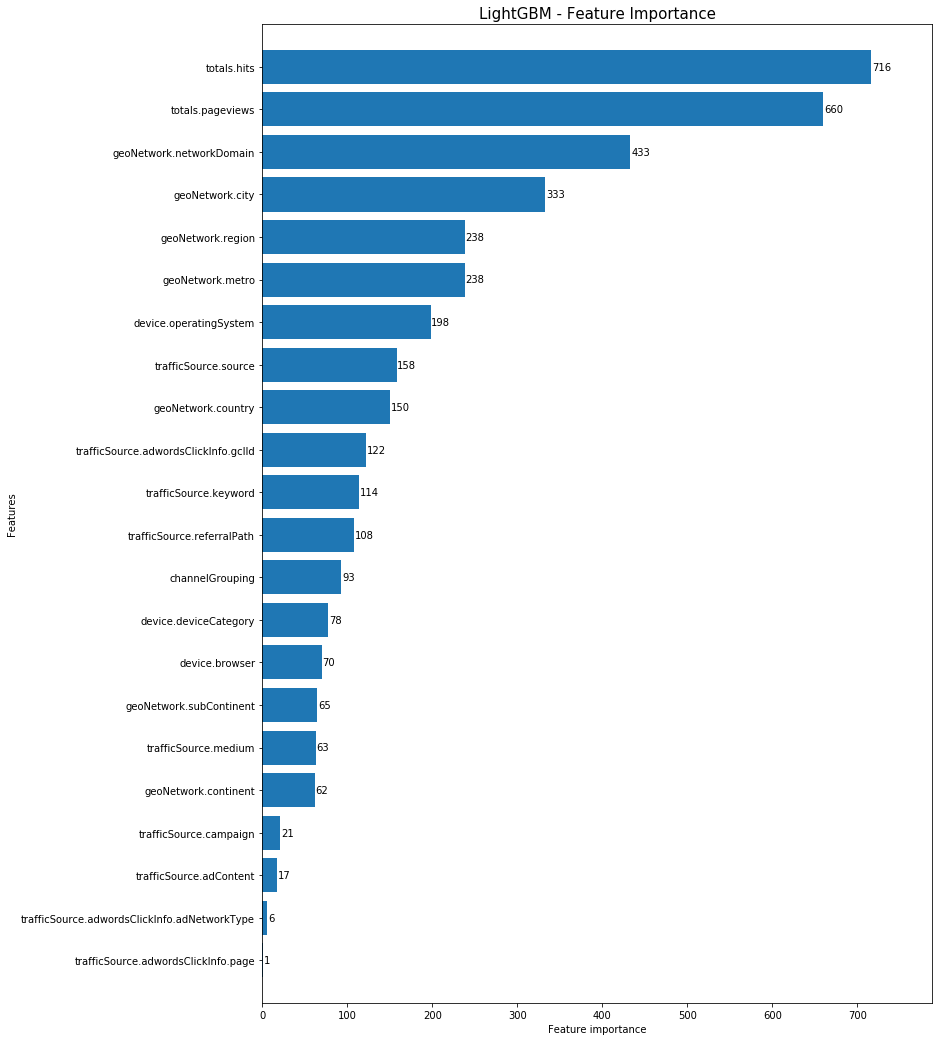

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()


"totals.hits" turn out to be the most important feature followed by "totals.vies". Network domain and city are next in line.